In [4]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [5]:
sns.color_palette("flare")
%matplotlib inline

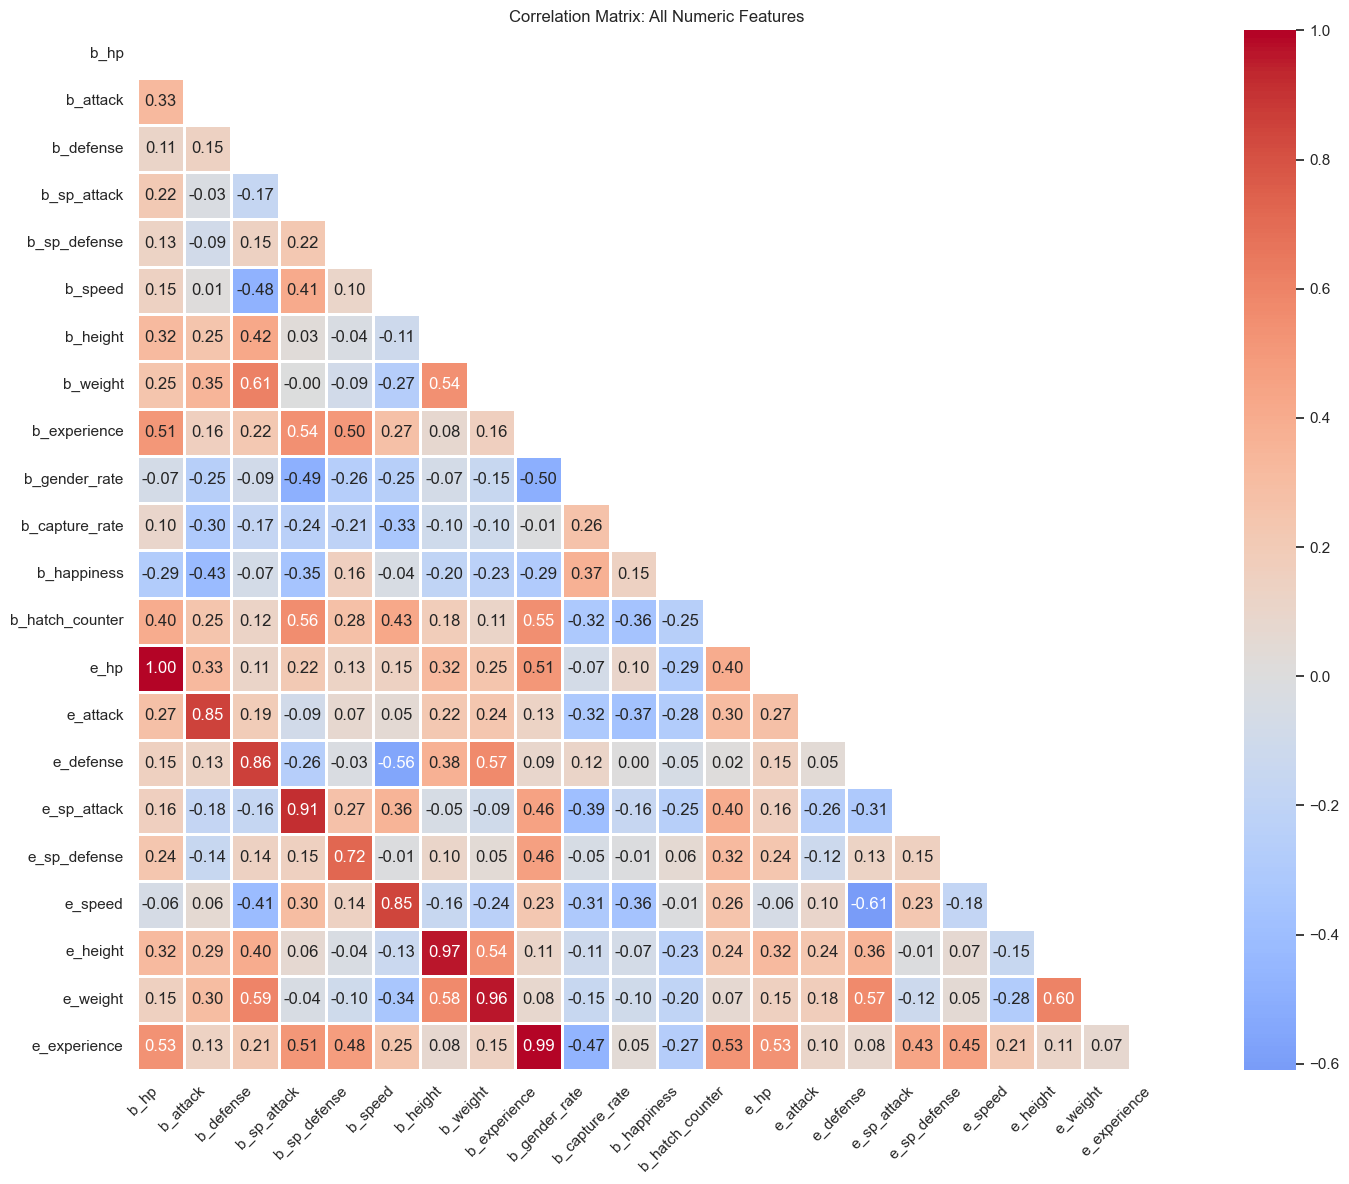

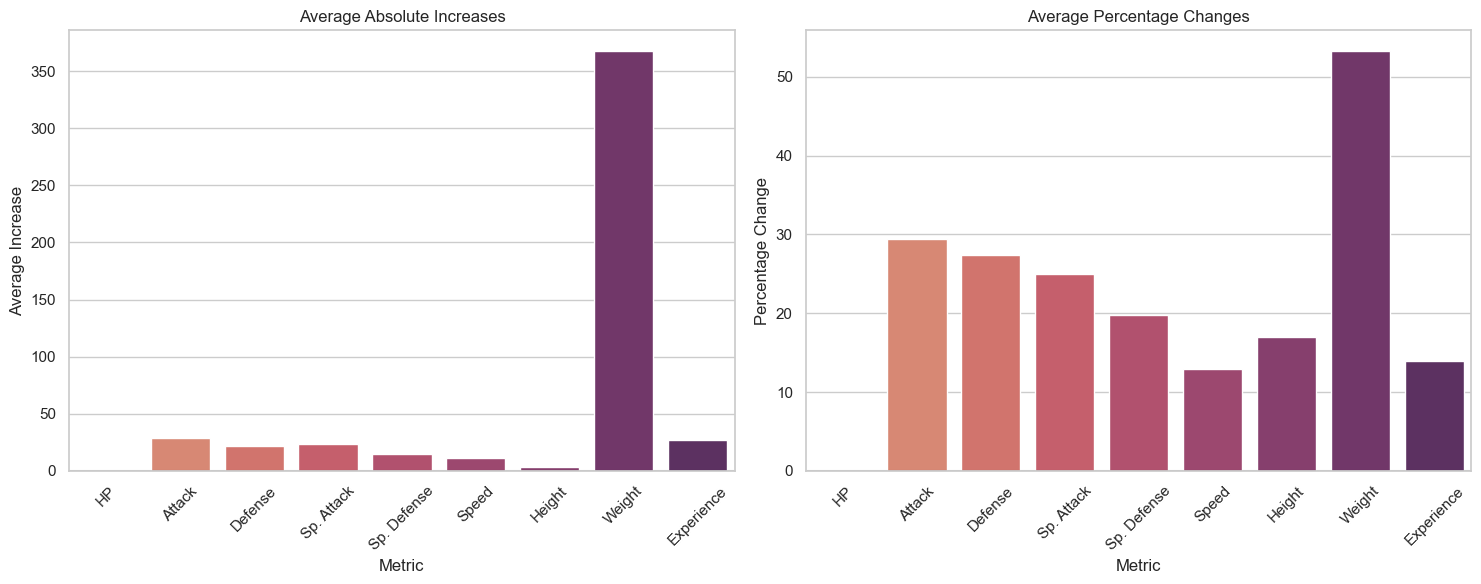

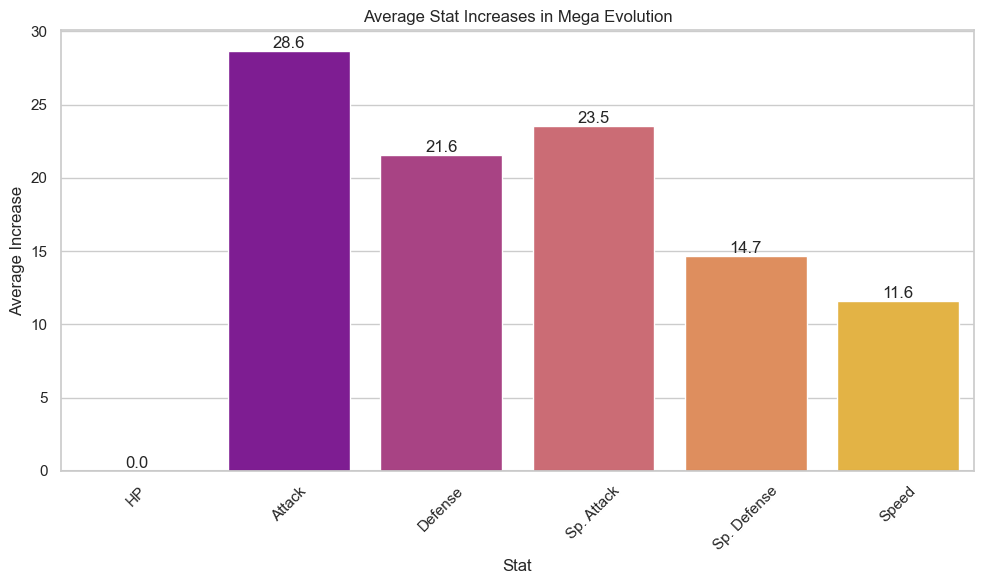

In [11]:
# Charger les données
df = pl.read_csv('../data/bronze_mega_evolutions.csv')

# 1. Matrice de corrélation complète
base_features = [
    'base_hp', 'base_attack', 'base_defense', 'base_sp_attack', 'base_sp_defense', 'base_speed',
    'base_height', 'base_weight', 'base_experience', 'base_gender_rate', 'base_capture_rate',
    'base_happiness', 'base_hatch_counter'
]

evolved_features = [
    'evolved_hp', 'evolved_attack', 'evolved_defense', 'evolved_sp_attack', 'evolved_sp_defense', 'evolved_speed',
    'evolved_height', 'evolved_weight', 'evolved_experience'
]

# Calculer la matrice de corrélation
stats_df = df.select(base_features + evolved_features)
corr_matrix = np.corrcoef(stats_df.to_numpy().T)

# Définir le style seaborn
sns.set(style='white')

# Créer une heatmap plus lisible
plt.figure(figsize=(15, 12))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

labels = [f.replace('base_', 'b_').replace('evolved_', 'e_') for f in (base_features + evolved_features)]

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            xticklabels=labels,
            yticklabels=labels)

plt.title('Correlation Matrix: All Numeric Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Les trois graphiques d'augmentation
common_metrics = [
    ('HP', 'base_hp', 'evolved_hp'),
    ('Attack', 'base_attack', 'evolved_attack'),
    ('Defense', 'base_defense', 'evolved_defense'),
    ('Sp. Attack', 'base_sp_attack', 'evolved_sp_attack'),
    ('Sp. Defense', 'base_sp_defense', 'evolved_sp_defense'),
    ('Speed', 'base_speed', 'evolved_speed'),
    ('Height', 'base_height', 'evolved_height'),
    ('Weight', 'base_weight', 'evolved_weight'),
    ('Experience', 'base_experience', 'evolved_experience')
]

stat_changes = pl.DataFrame({
    'Metric': [m[0] for m in common_metrics],
    'Average Increase': [
        df.select((pl.col(m[2]) - pl.col(m[1])).mean())[0,0]
        for m in common_metrics
    ],
    'Percentage Change': [
        df.select(((pl.col(m[2]) - pl.col(m[1])) / pl.col(m[1]) * 100).mean())[0,0]
        for m in common_metrics
    ]
})

# Définir le style seaborn
sns.set(style='whitegrid')

# Définir une palette avec le nombre exact d'éléments
palette = sns.color_palette("flare", len(common_metrics))

# Créer deux subplots côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des changements absolus
sns.barplot(data=stat_changes.to_pandas(), x='Metric', y='Average Increase', ax=ax1, hue='Metric', palette=palette, legend=False)
ax1.set_title('Average Absolute Increases')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax1.tick_params(axis='x', rotation=45)

# Graphique des changements en pourcentage
sns.barplot(data=stat_changes.to_pandas(), x='Metric', y='Percentage Change', ax=ax2, hue='Metric', palette=palette, legend=False)
ax2.set_title('Average Percentage Changes')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Graphique spécifique des stats
stat_pairs = [
    ('HP', 'base_hp', 'evolved_hp'),
    ('Attack', 'base_attack', 'evolved_attack'),
    ('Defense', 'base_defense', 'evolved_defense'),
    ('Sp. Attack', 'base_sp_attack', 'evolved_sp_attack'),
    ('Sp. Defense', 'base_sp_defense', 'evolved_sp_defense'),
    ('Speed', 'base_speed', 'evolved_speed')
]

stat_changes = pl.DataFrame({
    'Stat': [pair[0] for pair in stat_pairs],
    'Average Increase': [
        df.select((pl.col(pair[2]) - pl.col(pair[1])).mean())[0,0]
        for pair in stat_pairs
    ]
})

# Définir une palette de couleurs
stat_palette = sns.color_palette("plasma", len(stat_pairs))

plt.figure(figsize=(10, 6))
bars = sns.barplot(data=stat_changes.to_pandas(), x='Stat', y='Average Increase', hue='Stat', palette=stat_palette, legend=False)
plt.title('Average Stat Increases in Mega Evolution')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars.patches):
    value = stat_changes['Average Increase'][i]
    bars.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height(),
        f'{value:.1f}',
        ha='center',
        va='bottom'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Création d'un tableau de contingence pour voir les changements de type
if 'base_type1' in df.columns and 'evolved_type1' in df.columns:
    # Compter les occurrences de chaque combinaison de types
    type_contingency = (
        df.select(['base_type1', 'evolved_type1'])
        .group_by(['base_type1', 'evolved_type1'])
        .count()
        .sort('count', descending=True)
    )
    
    print("Tableau de contingence des types (base vs évolué):")
    print(type_contingency)
    
    # Pour une visualisation plus lisible sous forme de matrice
    # Pivot le tableau en matrice où les lignes sont les types de base et les colonnes les types évolués
    crosstab = df.select(['base_type1', 'evolved_type1']).to_pandas().pivot_table(
        index='base_type1', 
        columns='evolved_type1', 
        aggfunc=len, 
        fill_value=0
    )
    
    # Visualisation avec Seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Tableau de contingence: Type de base → Type évolué')
    plt.tight_layout()
    plt.show()
    

Colonnes non numériques: ['base_name', 'base_type_1', 'base_type_2', 'base_egg_group_1', 'base_egg_group_2', 'base_color', 'base_shape', 'base_habitat', 'base_generation', 'base_growth_rate', 'evolved_name', 'evolved_type_1', 'evolved_type_2']


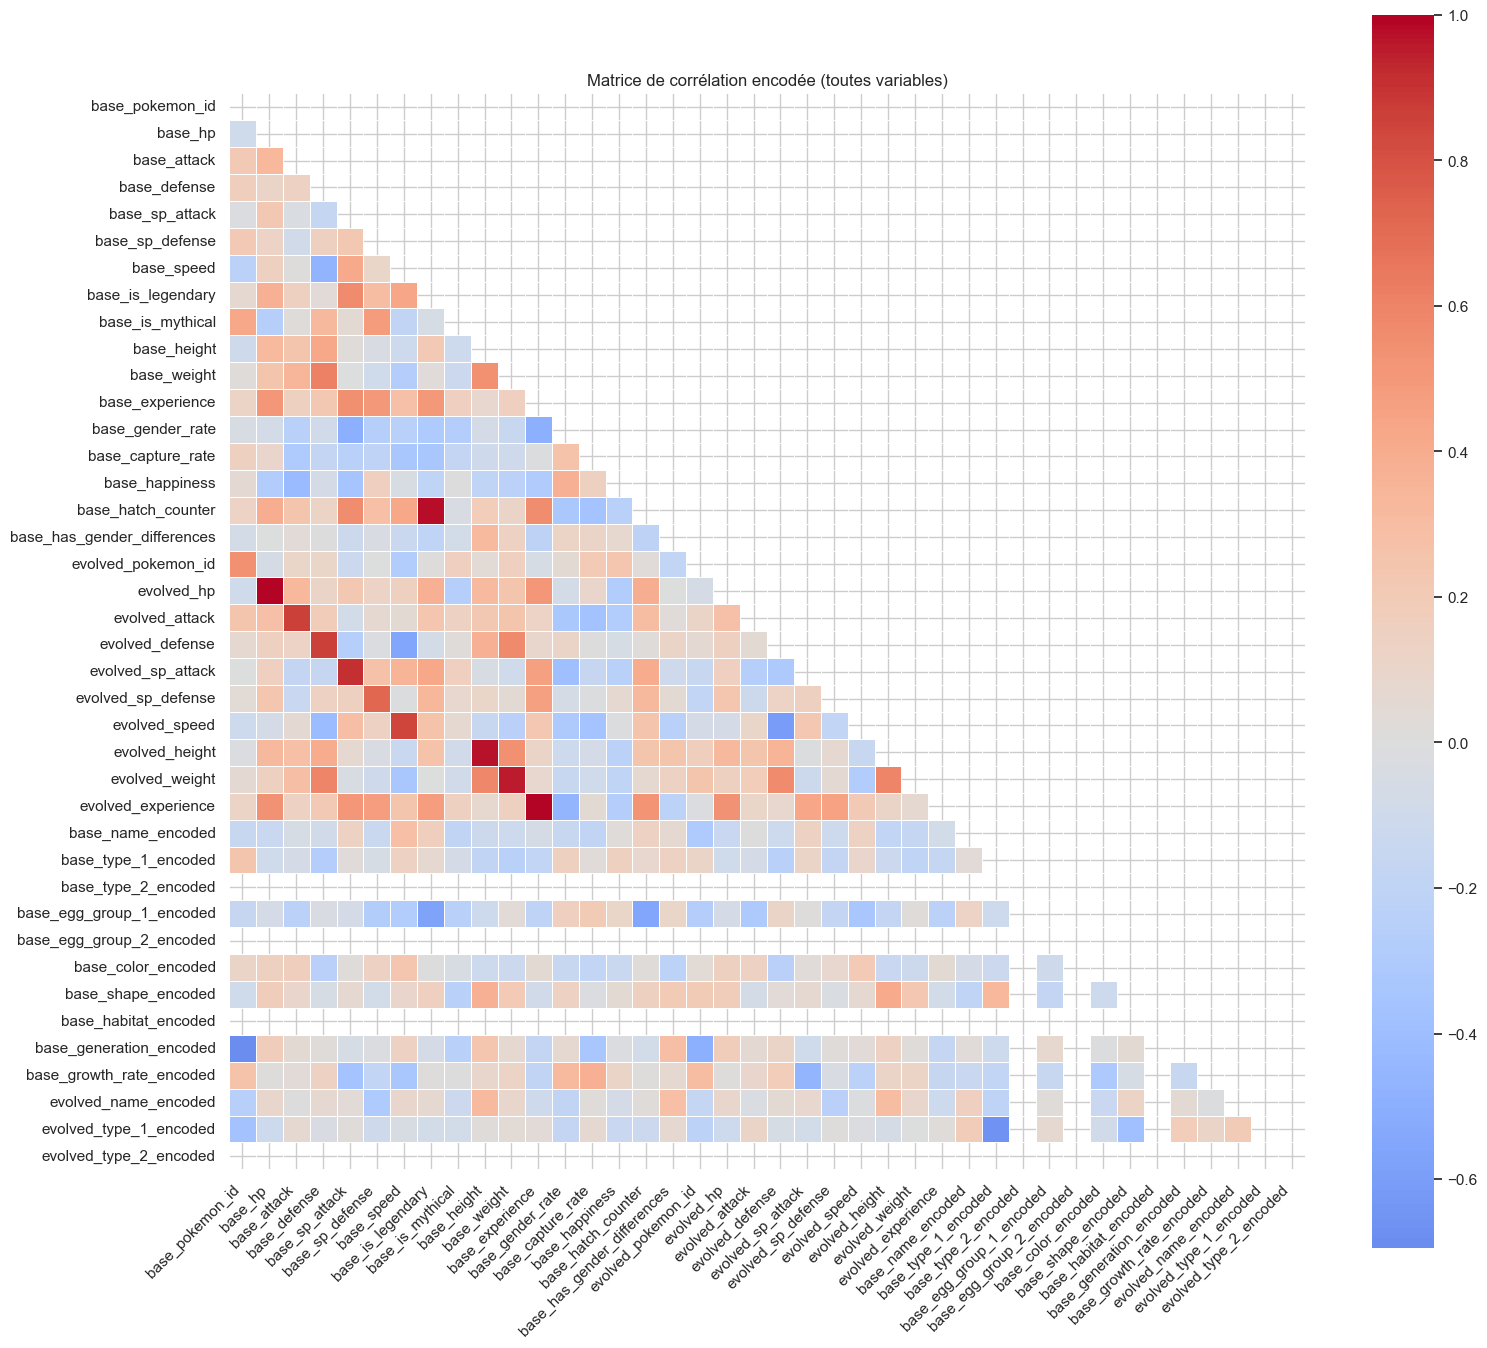

In [16]:
# Création d'une heatmap avec encodage des variables en restant dans Polars
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Identifier les colonnes non numériques
non_numeric_cols = []
for col in df.columns:
    # Vérifier si la colonne est de type chaîne
    if df[col].dtype == pl.Utf8 or df[col].dtype == pl.Categorical:
        non_numeric_cols.append(col)

print(f"Colonnes non numériques: {non_numeric_cols}")

# Créer une copie du DataFrame pour l'encodage
df_encoded = df.clone()

# Encoder les colonnes non numériques
for col in non_numeric_cols:
    # Extraire les valeurs uniques
    unique_values = df[col].unique().to_list()
    
    # Créer un mapping d'encodage
    encoder = {val: idx for idx, val in enumerate(unique_values)}
    
    # Appliquer l'encodage avec map_elements et spécifier le return_dtype
    df_encoded = df_encoded.with_columns([
        pl.col(col).map_elements(lambda x: encoder.get(x, -1), return_dtype=pl.Int32).alias(f"{col}_encoded")
    ])
    
    # Supprimer la colonne originale
    df_encoded = df_encoded.drop(col)

# Calculer la matrice de corrélation
corr_matrix = np.corrcoef(df_encoded.to_numpy().T)

# Créer des labels pour la matrice
labels = df_encoded.columns

# Créer la heatmap
plt.figure(figsize=(16, 14))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True  # Masquer la moitié supérieure

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=False,  # Pas d'annotations vu le nombre potentiellement élevé de variables
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            xticklabels=labels,
            yticklabels=labels)

plt.title('Matrice de corrélation encodée (toutes variables)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


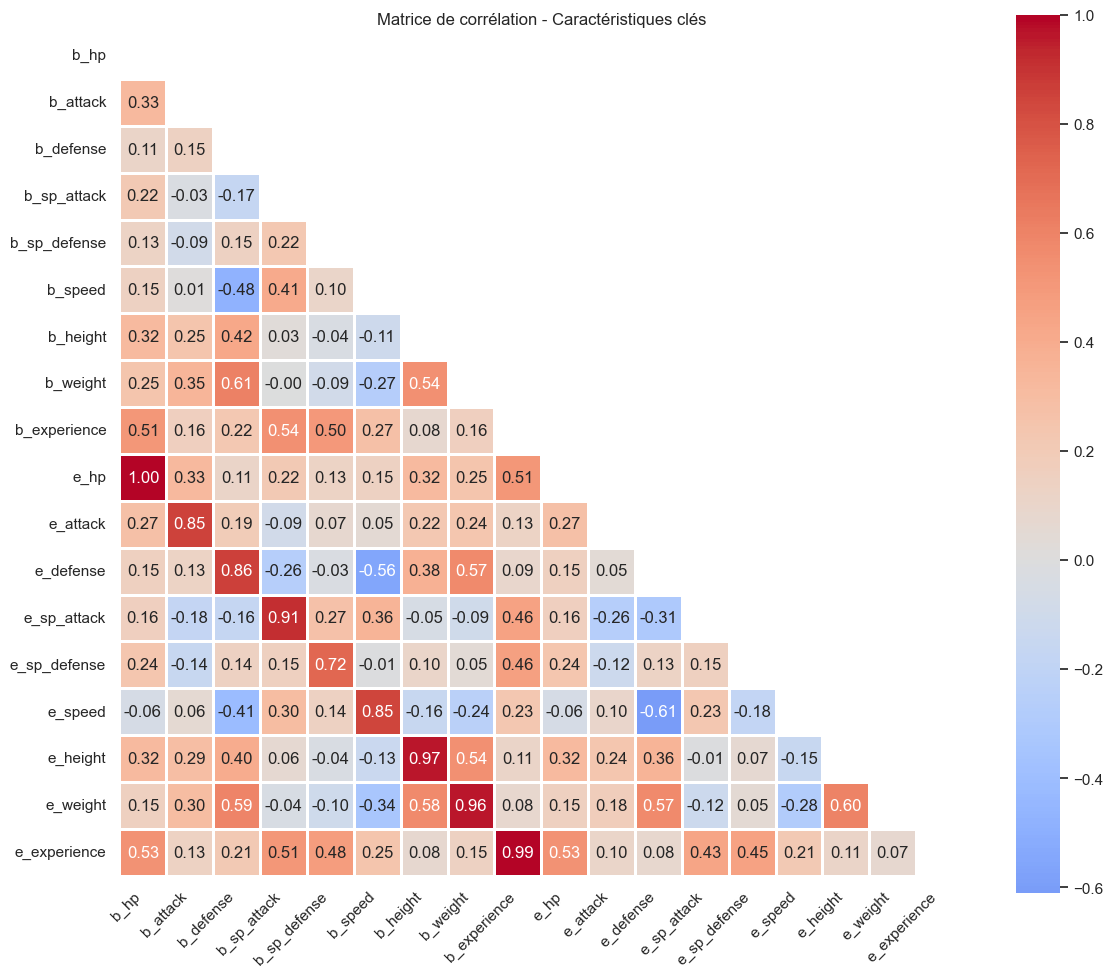

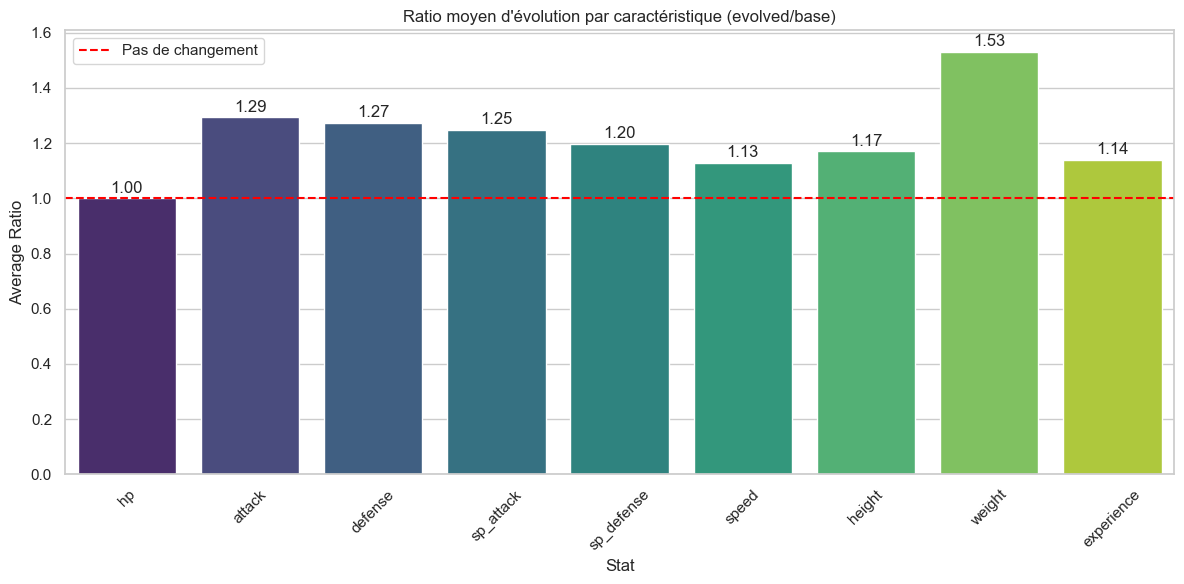

In [17]:
# Sélectionner uniquement les variables numériques importantes
key_features = [
    'base_hp', 'base_attack', 'base_defense', 'base_sp_attack', 'base_sp_defense', 'base_speed',
    'base_height', 'base_weight', 'base_experience'
]

evolved_features = [
    'evolved_hp', 'evolved_attack', 'evolved_defense', 'evolved_sp_attack', 'evolved_sp_defense', 'evolved_speed',
    'evolved_height', 'evolved_weight', 'evolved_experience'
]

# Créer un DataFrame réduit avec seulement ces caractéristiques
reduced_df = df.select(key_features + evolved_features)

# Calculer à nouveau la matrice de corrélation pour ces caractéristiques clés
reduced_corr_matrix = np.corrcoef(reduced_df.to_numpy().T)

# Visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.set(style='white')
mask = np.zeros_like(reduced_corr_matrix)
mask[np.triu_indices_from(mask)] = True

labels = [f.replace('base_', 'b_').replace('evolved_', 'e_') for f in (key_features + evolved_features)]

sns.heatmap(reduced_corr_matrix, 
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            xticklabels=labels,
            yticklabels=labels)

plt.title('Matrice de corrélation - Caractéristiques clés')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculer les ratios pour voir l'augmentation relative lors de l'évolution
evolution_ratios = pl.DataFrame({
    'Stat': [f.replace('base_', '') for f in key_features],
    'Average Ratio': [
        df.select((pl.col(evolved_features[i]) / pl.col(key_features[i])).mean())[0,0]
        for i in range(len(key_features))
    ]
})

# Visualiser les ratios d'évolution
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')
bars = sns.barplot(data=evolution_ratios.to_pandas(), x='Stat', y='Average Ratio', hue='Stat', palette='viridis', legend=False)
plt.axhline(y=1, color='red', linestyle='--', label='Pas de changement')
plt.title('Ratio moyen d\'évolution par caractéristique (evolved/base)')
plt.xticks(rotation=45)
plt.legend()

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars.patches):
    value = evolution_ratios['Average Ratio'][i]
    bars.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height() + 0.02,
        f'{value:.2f}',
        ha='center'
    )

plt.tight_layout()
plt.show()

In [18]:
# Sélectionner uniquement les variables numériques importantes
key_features = [
    'base_hp', 'base_attack', 'base_defense', 'base_sp_attack', 'base_sp_defense', 'base_speed',
    'base_height', 'base_weight', 'base_experience'
]

evolved_features = [
    'evolved_hp', 'evolved_attack', 'evolved_defense', 'evolved_sp_attack', 'evolved_sp_defense', 'evolved_speed',
    'evolved_height', 'evolved_weight', 'evolved_experience'
]

# Créer le DataFrame silver avec seulement ces caractéristiques
silver_df = df.select(key_features + evolved_features)
silver_df.write_csv('../data/silver_mega_evolutions.csv')